# Clone repository and install requirements

In [1]:
import sys
sys.path.append('C:/Users/asus/text2face/FGTD/scripts')

## Importing dependencies


In [2]:
import os
import random
import functools

import pandas as pd
import numpy as np
from numpy import sqrt, prod
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataclasses import asdict, dataclass

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import interpolate
from torch.nn.modules.utils import _pair
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [4]:
# File Constants
ZIP_PATH = "."
OUTPUT_DIR = "C:/Users/asus/text2face/FGTD/dataset/img_align_celeba/"

## Initialize constants

In [5]:
@dataclass
class Config:
    epochs: int = 600
    batch_size: int = 8
    subset_size: int = 20_000
    dataset_len = 202599

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    conditional: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    uncond_loss: int = 1.0
    colour_loss: int = 0.0
    kl_loss: int = 2.0

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
cfg = Config()
cfg_dict = asdict(cfg)

In [7]:
sentence_encoder = SentenceEncoder(cfg.device)

## Helper functions

In [8]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

# Create DataLoader

In [9]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'C:/Users/asus/text2face/FGTD/dataset/celebA_Bangla.csv',  
    image_location=OUTPUT_DIR,
    text_desc_location='C:/Users/asus/text2face/FGTD/dataset/text_1_bn_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'আকর্ষণীয়', 'টাই_পরা', 'কানের_দুল_পরা', 'নেকলেস_পরা', 'ফ্যাকাশে', 'বড়_নাক', 'কুচকানো_ভুরু', 'ভারী_মেকাপ', 'বড়_ঠোঁট', 'হালকা_দাড়ি', 'অল্পবয়স্ক', 'সামনের চুল কম', 'পুরুষ', 'কপালে_ছড়ানো_চুল', 'গোলাপী_গাল', 'সরু_চোখ', 'চশমা', 'সোজা_চুল', 'বাদামী_চুল', 'মোছ', 'ঢেউ_খেলানো_চুল', 'হাসি', 'দাড়ি_নেই', 'কালো_চুল', 'গোটি', 'দ্বীত্ব_থুতনি', 'চোখের_নিচে_কালি', 'লিপস্টিক_পরা', 'উঁচু_গালের_হাড়', 'জুলফি', 'সোনালী_চুল', 'টাক', 'চোখা_নাক', 'ডিম্বাকৃতির_চেহারা', 'মুখ_কিছুটা_খোলা', 'টুপি_পরা', 'Unnamed: 0', 'মোটা', 'ঘন_ভ্রু', 'ধূসর_চুল'}
Number of classes:  40
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing DataLoader output

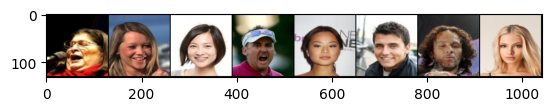

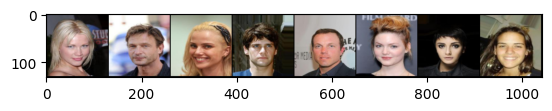

['ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের চোখে চশমা ছিল। ভদ্রলোকের মুখ কিছুটা খোলা ছিল। ভদ্রলোকের দাড়ি নেই। ', 'মেয়েটির চোখের নিচে কালি ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির সরু চোখ ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির সোজা চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির বড় ঠোঁট ছিল। মেয়েটির কালো চুল ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির সরু চোখ ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির সোজা চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের মুখ কিছুটা খোলা ছিল। ভদ্রলোকের দাড়ি নেই। ভদ্রলোকটির টুপি পরা ছিল। ', 'মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির কানে দুল পরা ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির সোনালী চুল ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির দাড়ি নেই। ছেলেটির মুখে ছিল হাসি। ছেলেটির সোজা চুল ছিল। ', 'ভদ্রলোকটির চোখের নিচে কালি ছিল। ভদ্রলোকের সরু চোখ ছিল। ভদ্রলোকটির সামনের

In [10]:
real_images, labels, wrong_images = weighted_dataiter._next_data()
show_grid(torchvision.utils.make_grid(real_images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Create Network

In [11]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [12]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    
    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)        

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [13]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch 
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [14]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )
    
  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training


In [16]:
netG = NetG(64, 100).to(device)

netG.cuda().train()

NetG(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (reduce_dim): Linear(in_features=768, out_features=256, bias=True)
  (block0): G_Block(
    (c1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (affine0): affine(
      (fc_gamma): Sequential(
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
      )
      (fc_beta): Sequential(
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
      )
    )
    (affine1): affine(
      (fc_gamma): Sequential(
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, 

In [17]:
generator_path = "C:/Users/asus/text2face/FGTD/Face-GANs/DFGAN/DFGAN_gd_generators/"

In [18]:
from facenet_pytorch import MTCNN, InceptionResnetV1

In [19]:
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)
metric = InceptionScore()
metric.attach(default_evaluator, "is")

In [20]:
def fsscalc(real,fake):
        # If required, create a face detection pipeline using MTCNN:
    mtcnn = MTCNN(
        image_size=128, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=0
    )

    # Create an inception resnet (in eval mode):
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    real = real.to(device='cpu')
    fake = fake.to(device='cpu')
    
    img_embedding1 = resnet(real)
    img_embedding2 = resnet(fake)

    cos = torch.nn.CosineSimilarity(dim=1)

    fss = torch.sum(cos(img_embedding1,img_embedding2))/8

    return fss

In [21]:
def fsdcalc(real,fake):
        # If required, create a face detection pipeline using MTCNN:
    mtcnn = MTCNN(
        image_size=128, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=0
    )

    # Create an inception resnet (in eval mode):
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    real = real.to(device='cpu')
    fake = fake.to(device='cpu')
    
    img_embedding1 = resnet(real)
    img_embedding2 = resnet(fake)

    fsd = torch.sum(torch.abs((img_embedding1-img_embedding2)))/8

    return fsd

# show FSD at each epoch

In [24]:
epoch_number = 0

for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    
    if(epoch_number>150):
        break
    
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    
    current_path = generator_path + str(epoch_number) + '.pt'
    netG.load_state_dict(torch.load(current_path)['generator_state_dict'])

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)
    
    print(float(fsdcalc(real_images,fake)))
    
    epoch_number+=5

25.104583740234375
23.637277603149414
20.36974334716797
22.701457977294922
24.006587982177734
23.12247085571289
25.321826934814453
22.223876953125
23.098453521728516
21.201101303100586
24.909868240356445


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/asus/text2face/FGTD/Face-GANs/DFGAN/DFGAN_gd_generators/55.pt'